In [1]:
import sys
!{sys.executable} -m pip install flask


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import nltk



In [3]:


fake = pd.read_csv("data/Fake.csv")
true = pd.read_csv("data/True.csv")

print("Fake news shape:", fake.shape)
print("True news shape:", true.shape)

fake.head()


Fake news shape: (23481, 4)
True news shape: (21417, 4)


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
fake["label"] = 0
true["label"] = 1

data = pd.concat([fake, true], axis=0)
data = data.sample(frac=1).reset_index(drop=True)  # shuffle the dataset

data = data[['title', 'text', 'label']]
data.head()


,title,text,label
0,George H. W. Bush Writes Letter Showing Trump...,Former President George H. W. Bush can teach D...,0
1,U.S. calls on Yemen's warring factions to re-e...,WASHINGTON (Reuters) - The United States is ca...,1
2,"Philippines orders retraining, reassignment of...",MANILA (Reuters) - The Philippine capital s po...,1
3,The Trump presidency on Jan 29 at 4:12 P.M. ES...,WASHINGTON (Reuters) - Jan 29 (Reuters) - High...,1
4,Dear Trump: ISIS Is NOT A Football Game,"When Donald Trump talks about America, he ofte...",0


label
0    23481
1    21417
Name: count, dtype: int64


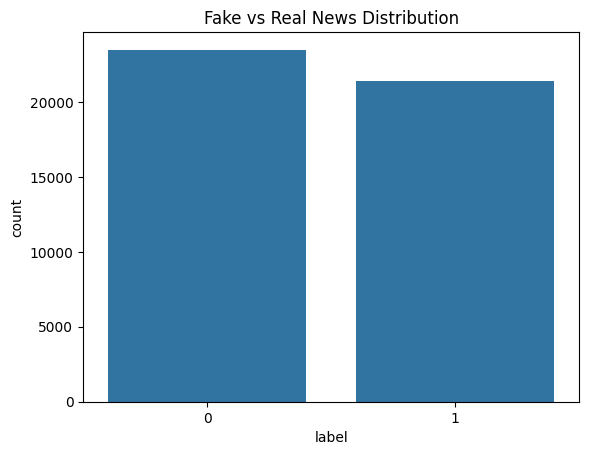

In [5]:
print(data['label'].value_counts())
sns.countplot(x='label', data=data)
plt.title("Fake vs Real News Distribution")
plt.show()


In [6]:
data['content'] = data['title'] + " " + data['text']
data = data[['content', 'label']]

print("Total samples:", data.shape[0])
data.head()


Total samples: 44898


,content,label
0,George H. W. Bush Writes Letter Showing Trump...,0
1,U.S. calls on Yemen's warring factions to re-e...,1
2,"Philippines orders retraining, reassignment of...",1
3,The Trump presidency on Jan 29 at 4:12 P.M. ES...,1
4,Dear Trump: ISIS Is NOT A Football Game When ...,0


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    data['content'], data['label'], test_size=0.2, random_state=42, stratify=data['label']
)
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 35918
Testing samples: 8980


In [12]:

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [9]:
model = LogisticRegression(max_iter=200)
model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=200)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      4696
           1       0.98      0.99      0.98      4284

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



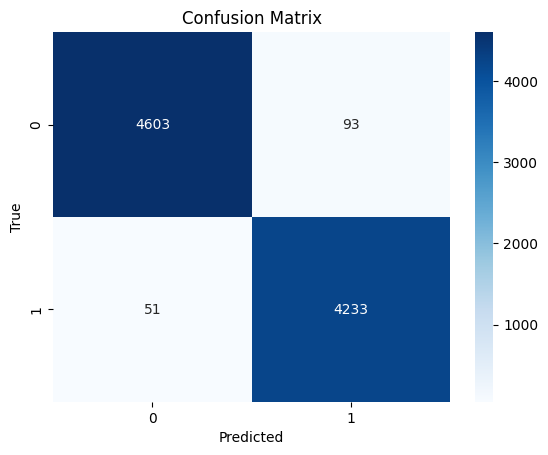

In [10]:
y_pred = model.predict(X_test_tfidf)

print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [13]:
def predict_news(text):
    text_tfidf = tfidf_vectorizer.transform([text])
    prediction = model.predict(text_tfidf)[0]
    if prediction == 0:
        print("❌ The news is FAKE.")
    else:
        print("✅ The news is REAL.")

# Try some examples
predict_news("The Prime Minister announced that aliens landed in Delhi today.")
predict_news("NASA successfully launched a new satellite for weather observation.")


❌ The news is FAKE.
❌ The news is FAKE.


In [15]:
joblib.dump(model, "fake_news_model.pkl")
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")
print("✅ Model and vectorizer saved successfully.")


✅ Model and vectorizer saved successfully.


In [16]:
loaded_model = joblib.load("fake_news_model.pkl")
loaded_vectorizer = joblib.load("tfidf_vectorizer.pkl")

sample = "Government announced new policy for digital education."
sample_vec = loaded_vectorizer.transform([sample])
pred = loaded_model.predict(sample_vec)[0]
print("Prediction:", "REAL" if pred == 1 else "FAKE")


Prediction: REAL


In [18]:
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
coefficients = model.coef_[0]
top_fake = feature_names[np.argsort(coefficients)[:20]]
top_real = feature_names[np.argsort(coefficients)[-20:]]

print("Top words indicating FAKE news:\n", top_fake)
print("\nTop words indicating REAL news:\n", top_real)


Top words indicating FAKE news:
 ['video' 'just' 'image' 'gop' 'hillary' 'featured' 'read' 'watch'
 'america' 'com' 'mr' 'getty' 'pic' 'images' 'like' 'wire' 'breaking'
 '21st' 'american' 'https']

Top words indicating REAL news:
 ['london' 'killed' 'year' 'told' 'reporters' 'democratic' 'statement'
 'comment' 'presidential' 'minister' 'spokesman' 'nov' 'monday' 'friday'
 'tuesday' 'thursday' 'republican' 'wednesday' 'washington' 'reuters']


In [19]:
!flask --version


Python 3.13.5
Flask 3.1.2
Werkzeug 3.1.3


In [20]:
import os
os.makedirs("model", exist_ok=True)


In [21]:
import pickle

# Save model
with open("model/fake_news_model.pkl", "wb") as f:
    pickle.dump(model, f)

# Save vectorizer
with open("model/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)
